In [2]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
# import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
import pyhrv

In [3]:
# Function that reads a csv file and outputs a data frame
def read_from_csv(file):
    data_frame = pd.read_csv(file, sep=",")
    return data_frame

In [30]:
# Function that writes a data frame to a csv file
def write_to_csv(df, file):
    df.to_csv(index=False)
    location = "C:/Users/riche/OneDrive/Documenten/Github/EPO4-C2/"
    path = location + file
    os.makedirs(location, exist_ok=True)  
    df.to_csv(path)

In [5]:
# filtering
def filter_signal(ecg, fs):
    nyq = 0.5*fs
    order=5

    # highpass filter
    high=0.5
    high= high/nyq
    b, a = butter(order, high, 'highpass')
    ecg_h = lfilter(b,a,ecg)

    # lowpass filter
    low = 70
    low= low/nyq
    b, a = butter(order, low, 'lowpass')
    ecg_hl = lfilter(b,a,ecg_h)

    # notch filter
    notch=50
    notch = notch/nyq
    b, a = iirnotch(notch, 30, fs)
    ecg_hln = lfilter(b,a,ecg_hl)

    t=np.arange(0,ecg.size*(1/fs),(1/fs))
    t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,ecg_hln, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend()
    return ecg_hln

In [6]:
# detect R-peaks
def detect_rpeaks(fs, ecg_hln):
    detectors = Detectors(fs)

    r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
    r_peaks_pan = np.asarray(r_peaks_pan)

    # plt.figure(figsize=(12,4))
    # plt.plot(ecg_hln)
    # plt.plot(r_peaks_pan,ecg_hln[r_peaks_pan], 'ro')
    return r_peaks_pan

# **Feature extraction**

In [22]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(r_peaks_pan, fs):
    plt.ioff()
    ecg_fft = pyhrv.frequency_domain.welch_psd(rpeaks = r_peaks_pan, show=False, show_param=False, legend=False,  detrend=False)
    plt.ion()
    hrv_class = HRV(fs)
    # print(r_peaks_pan)
    #Number of pairs of succesive NNs that differ by more than 20ms(NN20)
    feat_nn20=hrv_class.NN20(r_peaks_pan)
    # print(f"nn20:{feat_nn20}")
    #Number of pairs of succesive NNs that differ by more than 50ms(NN50)
    feat_nn50=hrv_class.NN50(r_peaks_pan)
    # print(f"nn50:{feat_nn50}")
    #Root mean square of succesive differences(RMSSD)
    feat_rmssd=hrv_class.RMSSD(r_peaks_pan, normalise= True)
    # print(f"rmssd:{feat_rmssd}")
    #Heart-rate feature extraction in BPM(HR)
    feat_hr=np.mean(hrv_class.HR(r_peaks_pan))
    # print(f"HR:{feat_hr}")
    #Standard deviation of succesive differences(SDSD)
    feat_sdsd=hrv_class.SDSD(r_peaks_pan)
    # print(f"SDSD:{feat_sdsd}")
    #The proportion of NN50 divided by total number of NNs(pNN50)
    feat_pnn50=hrv_class.pNN50(r_peaks_pan)
    # print(f"pNN50:{feat_pnn50}")
    #The proportion of NN20 divided by total number of NNs(pNN20)
    feat_pnn20=hrv_class.pNN20(r_peaks_pan)
    # print(f"pNN20:{feat_pnn20}")
    #The
    return [feat_nn20, feat_nn50, feat_rmssd, feat_hr, feat_sdsd, feat_pnn50, feat_pnn20, ecg_fft['fft_peak'][0], ecg_fft['fft_peak'][1],
            ecg_fft['fft_peak'][2], ecg_fft['fft_norm'][0],ecg_fft['fft_norm'][1], ecg_fft['fft_ratio'], ecg_fft['fft_total']]

In [31]:
# set up an empty features file
df_features = pd.DataFrame(None, columns= ['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 
                                     'feat_sdsd', 'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf','peak hf', 'norm power lf', 
                                     'norm power hf', 'power ratio', 'total power'])
#print(df_features)
write_to_csv(df_features, "out_features.csv")


In [32]:
# get features from all signals and write to a csv file

fs = 700
y = []
for label in range(1,5):
    file = "out_" + str(label) + ".csv"

    df = read_from_csv(file)

    for subject in df:
        if subject != 'Unnamed: 0':
            if label == 3 or label == 4:
                y.append(1)
            else:
                y.append(label)
            ecg = df[subject]
            filtered_ecg = filter_signal(ecg, fs)
            r_peaks_pan = detect_rpeaks(fs, filtered_ecg)
            features = get_features(r_peaks_pan, fs)
            df_features.loc[subject+str(label)] = features

write_to_csv(df_features, "out_features.csv")

In [36]:
df_features.head()
df_features.shape

(180, 14)

# **PCA**

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [35]:
df_features.keys()

Index(['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 'feat_sdsd',
       'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf', 'peak hf',
       'norm power lf', 'norm power hf', 'power ratio', 'total power'],
      dtype='object')

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3)
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(n_components=3) 
# pca = pca.fit(X_train)

# X_train_pca=pca.transform(X_train)
# X_test_pca=pca.transform(X_test)
# plt.figure(figsize=(8,6))
# plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# model = LogisticRegression()
# model.fit(X_train_pca, y_train)
# print(model.score(X_test_pca, y_test))

0.8148148148148148


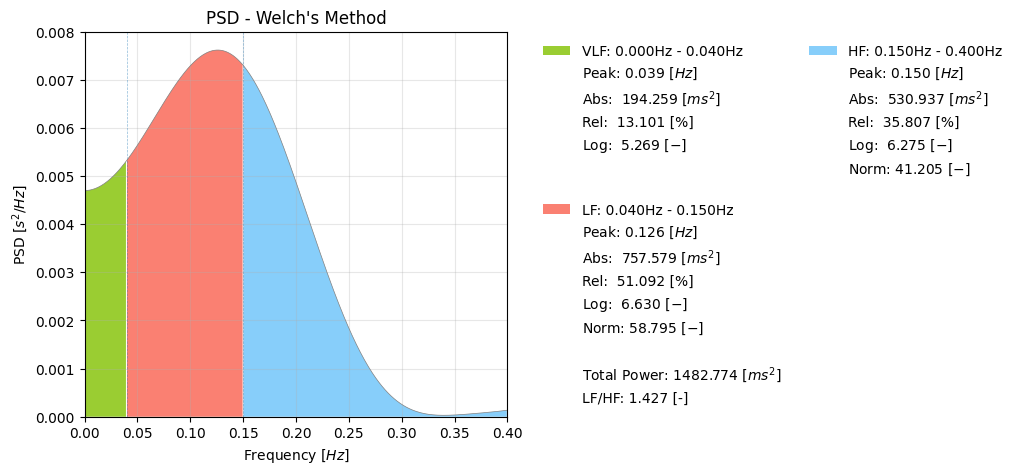

(58.79469181812502, 41.20530818187499)


<function matplotlib.pyplot.ion()>

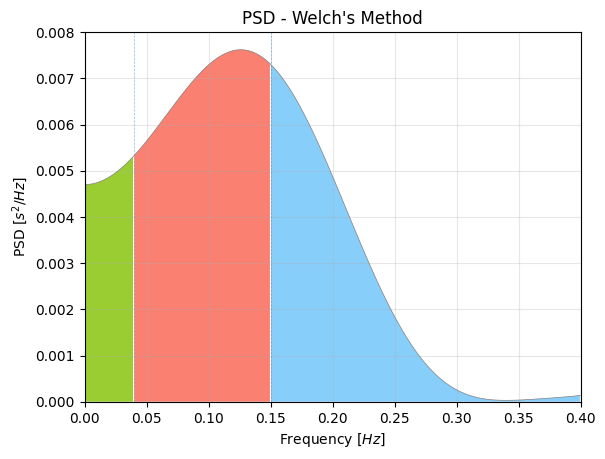

In [14]:
ecg_fft = pyhrv.frequency_domain.welch_psd(rpeaks = r_peaks_pan, show = False, show_param = False, legend = False)
plt.ion